In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

## Importing packages

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Flatten,Conv2D,MaxPool2D,Dropout
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Loading and Preprocessing the dataset

The dataset format is patterned to match closely with the classic MNIST. Each training and test case represents a label (0-25) as a one-to-one map for each alphabetic letter A-Z (and no cases for 9=J or 25=Z because of gesture motions). The training data (27,455 cases) and test data (7172 cases) are approximately half the size of the standard MNIST handwritten digit dataset but otherwise similar with a header row of label, pixel1,pixel2….pixel784 which represent a single 28x28 pixel image with grayscale values between 0-255.


In [3]:
train_df=pd.read_csv('./sign_mnist_train.csv')
test_df=pd.read_csv('./sign_mnist_test.csv')

train_df.info()
test_df.info()

train_df.describe()

train_df.head(6)

train_label=train_df['label']
train_label.head()
trainset=train_df.drop(['label'],axis=1)
trainset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27455 entries, 0 to 27454
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 164.4 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7172 entries, 0 to 7171
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 43.0 MB


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,107,118,127,134,139,143,146,150,153,156,...,207,207,207,207,206,206,206,204,203,202
1,155,157,156,156,156,157,156,158,158,157,...,69,149,128,87,94,163,175,103,135,149
2,187,188,188,187,187,186,187,188,187,186,...,202,201,200,199,198,199,198,195,194,195
3,211,211,212,212,211,210,211,210,210,211,...,235,234,233,231,230,226,225,222,229,163
4,164,167,170,172,176,179,180,184,185,186,...,92,105,105,108,133,163,157,163,164,179


## Pre-processing for the CNN

Converting the dataframe to numpy array type to be used while training the CNN. The array is converted from 1-D to 3-D which is the required input to the first layer of the CNN. Similar preprocessing is done to the test dataframe.

In [4]:
X_train = trainset.values
X_train = trainset.values.reshape(-1,28,28,1)
print(X_train.shape)

test_label=test_df['label']
X_test=test_df.drop(['label'],axis=1)
print(X_test.shape)
X_test.head()

(27455, 28, 28, 1)
(7172, 784)


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,149,149,150,150,150,151,151,150,151,152,...,138,148,127,89,82,96,106,112,120,107
1,126,128,131,132,133,134,135,135,136,138,...,47,104,194,183,186,184,184,184,182,180
2,85,88,92,96,105,123,135,143,147,152,...,68,166,242,227,230,227,226,225,224,222
3,203,205,207,206,207,209,210,209,210,209,...,154,248,247,248,253,236,230,240,253,255
4,188,191,193,195,199,201,202,203,203,203,...,26,40,64,48,29,46,49,46,46,53


## Converting the integer labels to binary form

The label dataframe consist of single values from 1 to 24 for each individual picture. The CNN output layer will be of 24 nodes since it has 24 different labels as a multi label classifier. Hence each integer is encoded in a binary array of size 24 with the corresponding label being 1 and all other labels are 0. Such as if y = 4 the the array is [0 0 0 1 0 0.....0]. The LabelBinarizer package from sklearn.preprocessing is used for that. 

The link to the part of documentation that I have referenced is https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html


In [5]:
from sklearn.preprocessing import LabelBinarizer
lb=LabelBinarizer()
y_train=lb.fit_transform(train_label)
y_test=lb.fit_transform(test_label)

y_train

X_test=X_test.values.reshape(-1,28,28,1)

print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(27455, 28, 28, 1) (27455, 24) (7172, 28, 28, 1) (7172, 24)


## Augmenting the image dataset to generate new data

ImageDataGenerator package from keras.preprocessing.image allows to add different distortions to image dataset by providing random rotation, zoom in/out , height or width scaling etc to images pixel by pixel.

Documentation that I referenced https://keras.io/preprocessing/image/

The image dataset in also normalised here using the rescale parameter which divides each pixel by 255 such that the pixel values range between 0 to 1.


In [6]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 0,
                                  height_shift_range=0.2,
                                  width_shift_range=0.2,
                                  shear_range=0,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

X_test=X_test/255

# Visualization of the Dataset

Preview of the images in the training dataset

Text(0.5, 1.0, 'label: 13  letter: M')

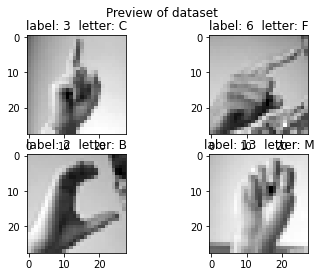

In [7]:
# Randomly select 4 images from the training set and display them with their labels
fig,axe=plt.subplots(2,2)
fig.suptitle('Preview of dataset')

axe[0,0].imshow(X_train[0].reshape(28,28),cmap='gray')
axe[0,0].set_title('label: 3  letter: C')

axe[0,1].imshow(X_train[1].reshape(28,28),cmap='gray')
axe[0,1].set_title('label: 6  letter: F')

axe[1,0].imshow(X_train[2].reshape(28,28),cmap='gray')
axe[1,0].set_title('label: 2  letter: B')

axe[1,1].imshow(X_train[4].reshape(28,28),cmap='gray')
axe[1,1].set_title('label: 13  letter: M')

# Building the CNN Model

The model consists of :

   1. Three convolution layer each followed bt MaxPooling for better feature capture
   2. A dense layer of 512 units
   3. The output layer with 26 units for 26 different classes (i.e., alphabets) and 2 additional for 'del', 'space' 



Convolution layers are:

Conv layer 1 -- UNITS - 128 KERNEL SIZE - 5 * 5 STRIDE LENGTH - 1 ACTIVATION - ReLu

Conv layer 2 -- UNITS - 64 KERNEL SIZE - 3 * 3 STRIDE LENGTH - 1 ACTIVATION - ReLu

Conv layer 3 -- UNITS - 32 KERNEL SIZE - 2 * 2 STRIDE LENGTH - 1 ACTIVATION - ReLu

MaxPool layer 1 -- MAX POOL WINDOW - 3 * 3 STRIDE - 2

MaxPool layer 2 -- MAX POOL WINDOW - 2 * 2 STRIDE - 2

MaxPool layer 3 -- MAX POOL WINDOW - 2 * 2 STRIDE - 2

In [8]:
model=Sequential()

model.add(Conv2D(128,kernel_size=(5,5), strides=1,padding='same',activation='relu',input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(3,3),strides=2,padding='same'))
model.add(Conv2D(64,kernel_size=(2,2), strides=1,activation='relu',padding='same'))
model.add(MaxPool2D((2,2),2,padding='same'))
model.add(Conv2D(32,kernel_size=(2,2), strides=1,activation='relu',padding='same'))
model.add(MaxPool2D((2,2),2,padding='same'))
          
model.add(Flatten())

# Dense and Output layer

model.add(Dense(units=512,activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=24,activation='softmax'))
model.summary()

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

# Train the model
model.fit(train_datagen.flow(X_train,y_train,batch_size=200),
         epochs = 35,
         validation_data=(X_test,y_test),
         shuffle=1
         )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 128)       3328      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          8224      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 32)         0

# Evaluation of the model

Passing the test set we seperated in the begining to the model to see how it performs when fed random generic input.

In [9]:
(ls,acc)=model.evaluate(x=X_test,y=y_test)

print('MODEL ACCURACY = {}%'.format(acc*100))

225/225 [==============================] - 2s 10ms/step - loss: 0.0343 - accuracy: 0.9907
MODEL ACCURACY = 99.06581044197083%
